### Popularne instancje QAP wraz z dokładnym minimum funkcji celu:

- Nug12 12 578 (OPT) (12,7,9,3,4,8,11,1,5,6,10,2)
- Nug14 14 1014 (OPT) (9,8,13,2,1,11,7,14,3,4,12,5,6,10) 
- Nug15 15 1150 (OPT) (1,2,13,8,9,4,3,14,7,11,10,15,6,5,12) 
- Nug16a 16 1610 (OPT) (9,14,2,15,16,3,10,12,8,11,6,5,7,1,4,13) 
- Nug16b 16 1240 (OPT) (16,12,13,8,4,2,9,11,15,10,7,3,14,6,1,5) 
- Nug17 17 1732 (OPT) (16,15,2,14,9,11,8,12,10,3,4,1,7,6,13,17,5)
- Nug18 18 1930 (OPT) (10,3,14,2,18,6,7,12,15,4,5,1,11,8,17,13,9,16) 
- Nug20 20 2570 (OPT) (18,14,10,3,9,4,2,12,11,16,19,15,20,8,13,17,5,7,1,6) 
- Nug21 21 2438 (OPT) (4,21,3,9,13,2,5,14,18,11,16,10,6,15,20,19,8,7,1,12,17) 
- Nug22 22 3596 (OPT) (2,21,9,10,7,3,1,19,8,20,17,5,13,6,12,16,11,22,18,14,15) 
- Nug24 24 3488 (OPT) (17,8,11,23,4,20,15,19,22,18,3,14,1,10,7,9,16,21,24,12,6,13,5,2) 
- Nug25 25 3744 (OPT) (5,11,20,15,22,2,25,8,9,1,18,16,3,6,19,24,21,14,7,10,17,12,4,23,13) * 
- Nug27 27 5234 (OPT) (23,18,3,1,27,17,5,12,7,15,4,26,8,19,20,2,24,21,14,10,9,13,22,25,6,16,11) * 
- Nug28 28 5166 (OPT) (18,21,9,1,28,20,11,3,13,12,10,19,14,22,15,2,25,16,4,23,7,17,24,26,5,27,8,6) * 
- Nug30 30 6124 (OPT) (5 12 6 13 2 21 26 24 10 9 29 28 17 1 8 7 19 25 23 22 11 16 30 4 15 18 27 3 14 20)

## Zadanie 1.
Zapoznaj się z algorytmem symulowanego wyżarzania (ang. Simulated Annealing, SA) wykonując skrypt Pythona umieszczony w materiałach do wykładu. Przedstawia on zastosowanie algorytmu SA do rozwiązywania problemu Quadratic Assignment Problem (QAP) omówionego na wykładzie.

In [23]:
import numpy as np
import pandas as pd
from tqdm import tqdm, trange

from itertools import accumulate

import matplotlib.pyplot as plt
import urllib.request
from urllib.error import HTTPError

In [2]:
def get_nug(no):
    QAP_INSTANCE_URL = f'http://anjos.mgi.polymtl.ca/qaplib/data.d/nug{no}.dat'
    
    qap_instance_file = urllib.request.urlopen(QAP_INSTANCE_URL)

    line = qap_instance_file.readline()
    n = int(line.decode()[:-1].split()[0])

    A = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        A[i, :] = list(map(int, line.decode()[:-1].split()))

    B = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        B[i, :] = list(map(int, line.decode()[:-1].split()))
        
    return n, A, B

In [58]:
class SA:
    
    def __init__(self, no, T=25000, alpha=1, radius=1, with_tqdm=True):
        self.no = no
        self.loaded = True
        try:
            self.n, self.flow, self.dist = get_nug(no)
        except HTTPError:
            print(f'NUG{no} not found!')
            self.loaded = False
        self.T = T
        self.alpha = alpha
        self.radius = radius
        self.costs = np.zeros(T)
        self.with_tqdm = with_tqdm
    
    def _qap_objective_function(self, perm):
        s = 0.0
        for i in range(self.n):
            s += (self.flow[i, :] * self.dist[perm[i], perm]).sum()
        return s
    
    def _random_neighbour(self, p, radius):
        q = p.copy()
        for r in range(radius):
            i, j = np.random.choice(self.n, 2, replace=False)
            q[i], q[j] = q[j], q[i]
        return q

    def _perm_diff(self, p, q):
        return np.count_nonzero(p != q)
    
    def run(self):
        if not self.loaded:
            return
        
        p = np.random.permutation(self.n)
        p_cost = self._qap_objective_function(p)
        self.successes = np.zeros(self.T)
        self.accepted_losses = np.zeros(self.T)
        self.perm_cost_diff = np.zeros(self.n)
        
        if self.with_tqdm:
            range_ = trange(self.T, desc='simulating', position=0, leave=True)
        else:
            range_ = range(self.T)
        
        for t in range_:
            q = self._random_neighbour(p, self.radius)
            q_cost = self._qap_objective_function(q)
            
            if q_cost < p_cost:
                self.successes_jump[t] = 1
                p, p_cost = q, q_cost
                self.perm_cost_diff[self._perm_diff(p, q)] += p_cost - q_cost
                
            elif np.random.rand() < np.exp(-self.alpha * (q_cost - p_cost) * t/self.T):
                self.accepted_losses[t] = 1
                p, p_cost = q, q_cost
                
            self.costs[t] = p_cost
    
    def plot_costs(self):
        if not self.loaded:
            return
        plt.figure()
        plt.title(f'Simulated Annealing for NUG{self.no}')
        plt.xlabel('Temp')
        plt.ylabel('Cost')
        plt.plot(self.costs)
        plt.show()
    
    def plot_succ_and_accpt_loss(self):
        no_bars = 100
        no_intervals = self.T // no_bars
        succ = self.successes.reshape(no_intervals, -1)
        succ = succ.sum(axis=1)
        
        acpt = self.accepted_losses.reshape(no_intervals, -1)
        acpt = acpt.sum(axis=1)
        
        fig, ax = plt.subplots(1, 2, figsize=(16, 5))
        
        ax[0].set_title('Successes')
        ax[0].bar(np.arange(no_bars)*no_intervals,
               succ,
               50, color='g')
        
        ax[1].set_title('Accepted losses')
        ax[1].bar(np.arange(no_bars)*no_intervals,
                acpt,
                50, color='r')
        plt.show()
    
    def plot_jumps(self):
        

#### a) Postaraj się dobrać parametry algorytmu SA umożliwiające rozwiązywanie problemu QAP dla kilku innych instancji.

simulating: 100%|██████████| 25000/25000 [00:03<00:00, 7782.69it/s]


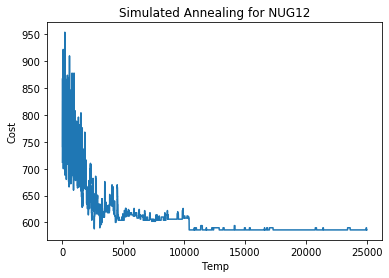

NUG12 min_cost: 586.0
NUG13 not found!


simulating: 100%|██████████| 25000/25000 [00:03<00:00, 7459.50it/s]


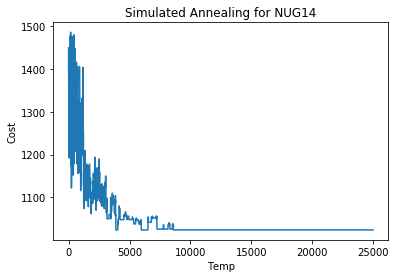

NUG14 min_cost: 1024.0


simulating: 100%|██████████| 25000/25000 [00:03<00:00, 6904.07it/s]


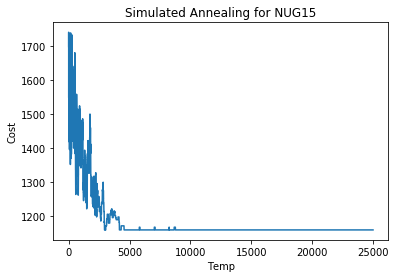

NUG15 min_cost: 1160.0
NUG16 not found!


simulating: 100%|██████████| 25000/25000 [00:03<00:00, 6413.33it/s]


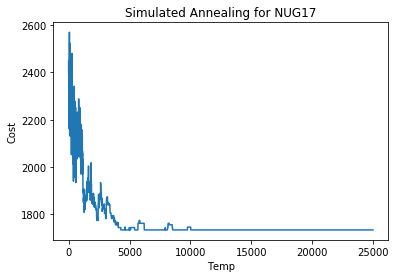

NUG17 min_cost: 1734.0


simulating: 100%|██████████| 25000/25000 [00:04<00:00, 6187.05it/s]


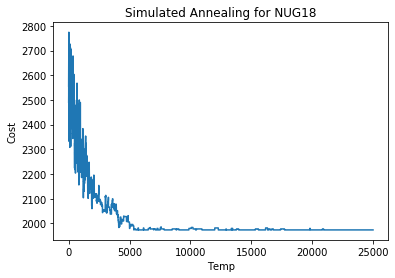

NUG18 min_cost: 1974.0
NUG19 not found!


simulating: 100%|██████████| 25000/25000 [00:04<00:00, 5660.14it/s]


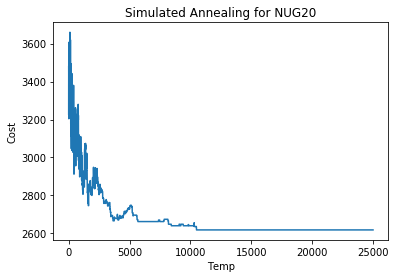

NUG20 min_cost: 2618.0


In [4]:
NUGS = np.arange(12, 21)

for nug in NUGS:
    sa = SA(nug)
    sa.run()
    sa.plot_costs()
    if sa.success:
        print(f'NUG{nug} min_cost: {sa.costs.min()}')

#### b) Histogram w skrypcie pokazuje jaki jest rozkład wartości funkcji celu dla rozwiązań generowanych losowo. Zrób podobny histogram dla rozwiązań generowanych algorytmem SA (dla ustalonej instancji QAP i ustalonych parametrów algorytmu). Będzie to wymagać wielu uruchomień algorytmu i zapewne długich obliczeń.

In [5]:
nug_no = 20
no_tries = 1000
T = 10000
costs = np.zeros(no_tries)

for i in trange(no_tries, position=0, leave=True):
    sa = SA(nug_no, T=T, with_tqdm=False)
    sa.run()
    costs[i] = sa.costs.min()

100%|██████████| 1000/1000 [36:59<00:00,  2.22s/it]


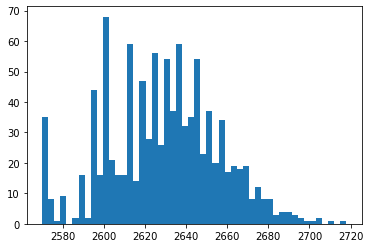

Mean: 2629.006, std: 27.146122448703426


In [7]:
plt.hist(costs, bins=50)
plt.show()

print(f'Mean: {costs.mean()}, std: {costs.std()}')

#### c) Sprawdź ile jest "sukcesów" (rozwiązanie q lepsze niż rozwiązanie p) i "akceptowanych porażek" (rozwiązanie q gorsze niż rozwiązanie p, ale zaakceptowane) w kolejnych iteracjach algorytmu SA (w miarę upływu czasu, "sukcesy" i "akceptowalne porażki" są coraz rzadsze) dla kilku wybranych ustawień parametrów algorytmu. Zilustruj to zjawisko wykresem.

simulating: 100%|██████████| 10000/10000 [00:01<00:00, 7842.11it/s]


Plots for alpha: 0.5


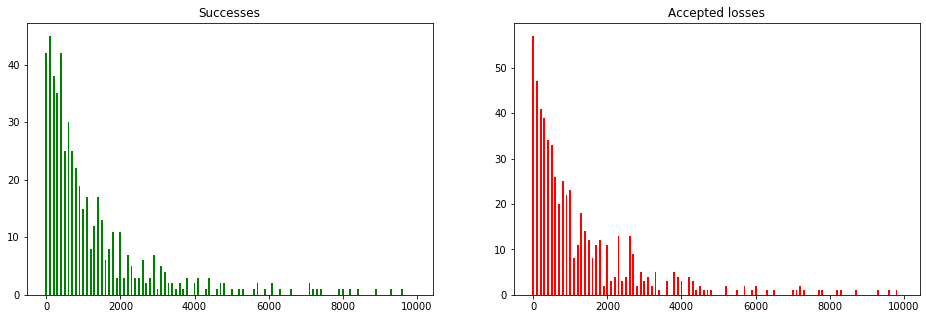

simulating: 100%|██████████| 10000/10000 [00:01<00:00, 7749.15it/s]


Plots for alpha: 0.6


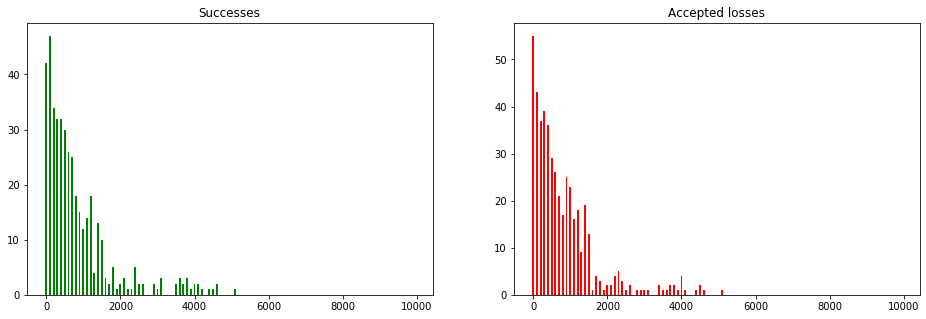

simulating:  41%|████      | 4091/10000 [00:11<00:00, 8169.22it/s]

Plots for alpha: 0.7


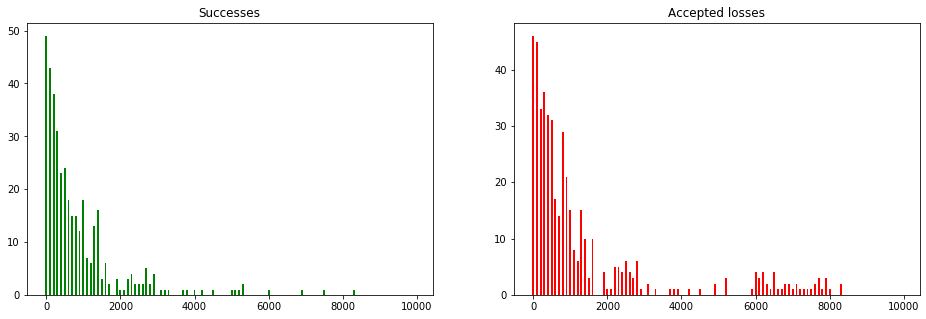

simulating: 100%|██████████| 10000/10000 [00:01<00:00, 7315.09it/s]


Plots for alpha: 0.8


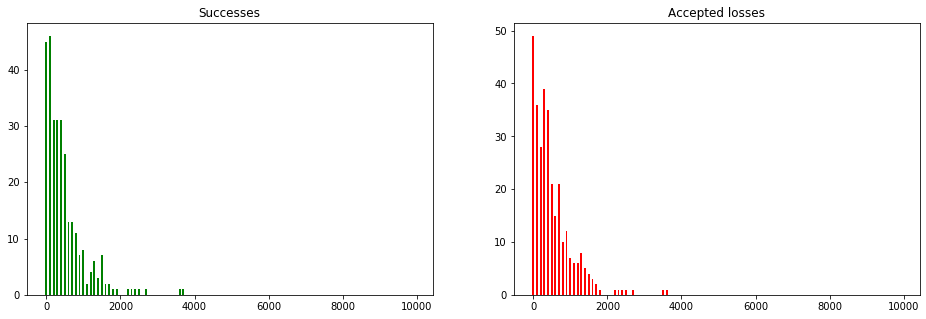

simulating: 100%|██████████| 10000/10000 [00:01<00:00, 7372.82it/s]


Plots for alpha: 0.9


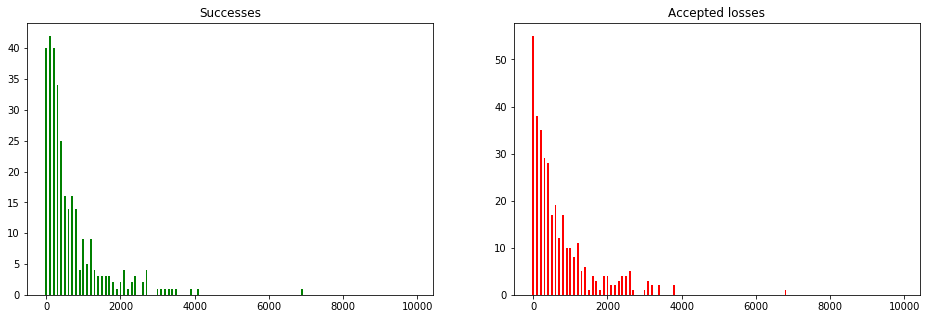

simulating: 100%|██████████| 10000/10000 [00:01<00:00, 8944.41it/s]


Plots for alpha: 1.0


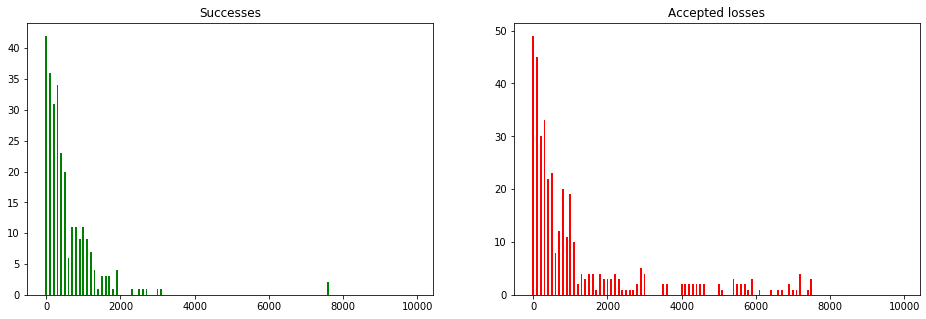

simulating: 100%|██████████| 10000/10000 [00:01<00:00, 7513.00it/s]


Plots for alpha: 1.1


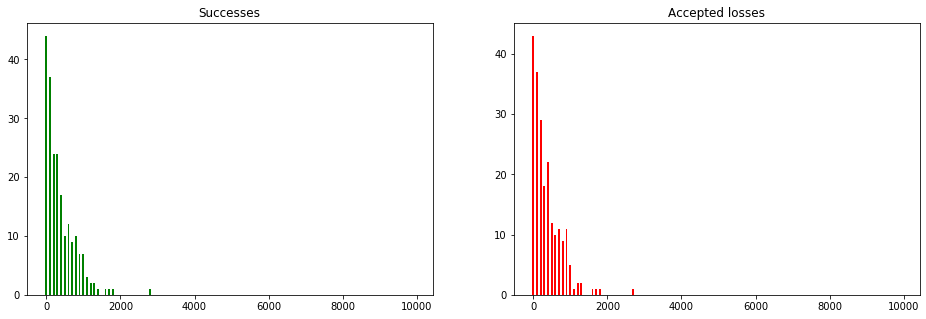

simulating: 100%|██████████| 10000/10000 [00:01<00:00, 7205.65it/s]


Plots for alpha: 1.2


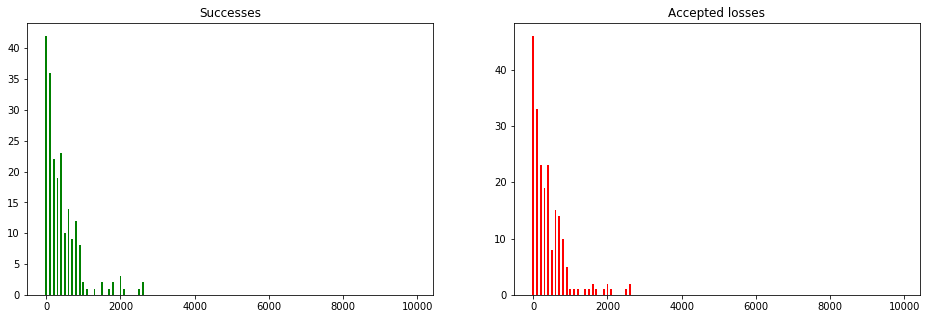

simulating: 100%|██████████| 10000/10000 [00:01<00:00, 7196.63it/s]


Plots for alpha: 1.3


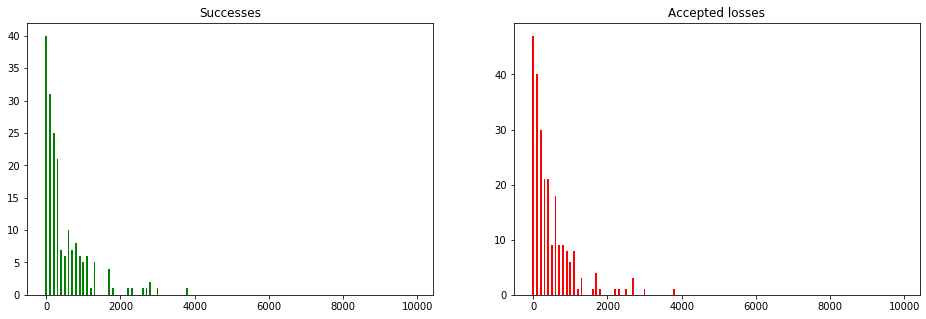

simulating: 100%|██████████| 10000/10000 [00:01<00:00, 6947.03it/s]


Plots for alpha: 1.4


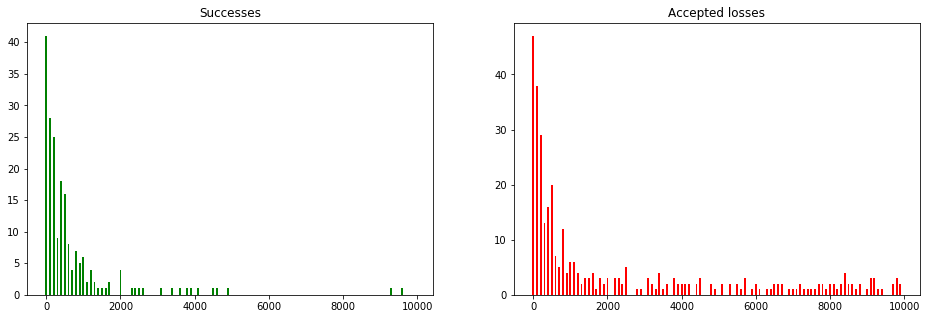

simulating: 100%|██████████| 10000/10000 [00:01<00:00, 7581.35it/s]


Plots for alpha: 1.5


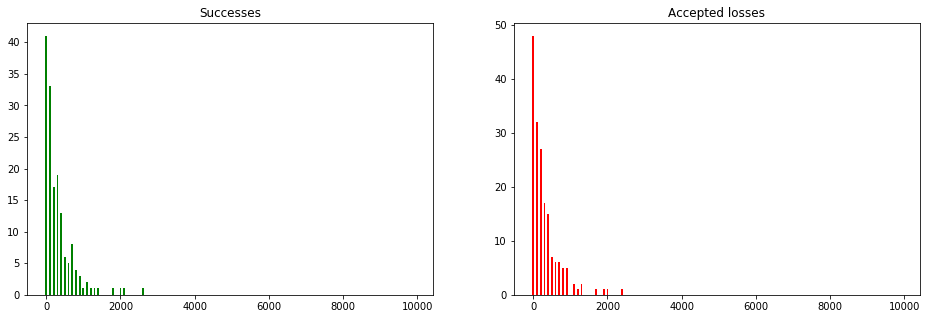

In [59]:
for alpha in np.arange(0.5, 1.6, 0.1):
    sa = SA(no=12, alpha=alpha, T=10000)
    sa.run()
    print(f'Plots for alpha: {np.round(alpha, 1)}')
    sa.plot_succ_and_accpt_loss()

#### d) Jak można mierzyć odległość między permutacjami? Sprawdź jaka jest zależność między zmianami wartości funkcji celu f(p) - f(q) w sukcesach, a odległością między permutacjami p i q. Zilustruj to wykresem.